In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the Excel file
file_path = r"C:\Users\Miranda Córdova\Downloads\Verano Cientifico\Datos_para trabajar\15_sib_rangos.xlsx" 
xls = pd.ExcelFile(file_path)

In [3]:
# Ver hojas disponibles
print(xls.sheet_names)


['Sheet1']


In [4]:
# Leer una hoja específica como DataFrame
df = xls.parse('Sheet1')  # o el nombre correcto de la hoja


In [5]:

# Crear una columna auxiliar con los pares ordenados (conjuntos)
df["sample_pair"] = df.apply(lambda row: frozenset([row["FAM_Sample_info"], row["VIC_Sample_info"]]), axis=1)
df1 =df
# Eliminar duplicados de esos pares (sin importar el orden)
df = df[~df.duplicated(subset="sample_pair")]

# Eliminar también donde ambos valores son exactamente iguales
df = df[df["FAM_Sample_info"] != df["VIC_Sample_info"]]

# Eliminar la columna auxiliar si ya no se necesita
df = df.drop(columns="sample_pair")

print("Filas luego del filtrado:", df.shape[0])



Filas luego del filtrado: 241599


In [132]:
df1.shape[0]

40418

In [244]:
df.columns

Index(['Shared_Markers', 'k0', 'k1', 'k2', 'Share_allele', 'Value',
       'True_positive', 'Datos', 'Value_range', 'log10_Value',
       'variable_rangos_encoded'],
      dtype='object')

In [149]:
df['True_positive'].unique()
#array(['BlindSeach', 'BlindSearch', 'ScreenMatch'], dtype=object)
#array(['Simulados', 'Real'], dtype=object)


array([False,  True])

In [116]:
df2 =df

In [198]:
df["Datos"].unique()

array(['Simulados'], dtype=object)

In [190]:
df=df2

In [191]:
df = df[
    (df['Datos'] == 'Simulados') 
]

In [193]:
# Asegúrate de que True_positive sea booleana
df["True_positive"] = df["True_positive"].astype(str).str.upper().map({"TRUE": True, "FALSE": False})

# Eliminar columnas no deseadas
df = df.drop(columns=["FAM_Sample_info", "VIC_Sample_info",'Hoja','Sheet',"File",'Marcadores','Software','Kinship'], errors='ignore')

# Seleccionar solo columnas numéricas
num_cols = df.select_dtypes(include='number').columns.tolist()

# Si hay una columna de clasificación (e.g., "Classification"), inclúyela
if "Classification" in df.columns:
    hue_var = "Classification"
else:
    hue_var = "True_positive"



C:\Users\Miranda Córdova\AppData\Local\Temp\ipykernel_29140\2725347750.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["True_positive"] = df["True_positive"].astype(str).str.upper().map({"TRUE": True, "FALSE": False})


In [197]:
import numpy as np

# Transformar LR (Value) a log10, cuidando ceros o valores negativos
df["log10_Value"] = np.log10(df["Value"].replace(0, np.nan)).replace(-np.inf, 0).fillna(0)


In [199]:
from sklearn.preprocessing import OrdinalEncoder
# Codificación Ordinal para la variable de rangos
# Definir el orden correcto de las categorías
range_categories = ['0-99', '100-999', '1000-9999', '10000-99999', '100000-999999', '1000000+']

ordinal_encoder = OrdinalEncoder(categories=[range_categories]) # Pasar categories en una lista
df['variable_rangos_encoded'] = ordinal_encoder.fit_transform(df[['Value_range']])


In [200]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [206]:
# Selección de variables predictoras
#features = ["k1", "k2", "Kinship_codificada", "Share_allele", "log10_Value"]
features = ["k1", "k2", "variable_rangos_encoded", "Kinship_codificada","Share_allele"]

X = df[features]
y = df["True_positive"].astype(bool)

In [207]:

# División
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Resultados
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.99      0.98      1059
        True       0.90      0.79      0.84       113

    accuracy                           0.97      1172
   macro avg       0.94      0.89      0.91      1172
weighted avg       0.97      0.97      0.97      1172



In [22]:
features = ["k1", "k2", "Share_allele", "log10_Value"]
X = df[features]
y = df["True_positive"].astype(bool)

In [23]:

# División
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Resultados
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1059
        True       0.86      0.84      0.85       113

    accuracy                           0.97      1172
   macro avg       0.92      0.91      0.92      1172
weighted avg       0.97      0.97      0.97      1172



In [212]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [213]:
# ✅ 1. Define las features y target
#features = ["k1", "k2", "Share_allele", "log10_Value"]
features = ["k1", "k2", "variable_rangos_encoded"]

target = "True_positive"  # Ajusta si tu columna tiene otro nombre


In [214]:
# ✅ 2. Divide en entrenamiento y prueba
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ 3. Crea y ajusta el modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)

# ✅ 4. Predicciones
y_pred = rf.predict(X_test)

# ✅ 5. Reporte de métricas
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.97      0.98       707
        True       0.76      0.99      0.86        75

    accuracy                           0.97       782
   macro avg       0.88      0.98      0.92       782
weighted avg       0.98      0.97      0.97       782



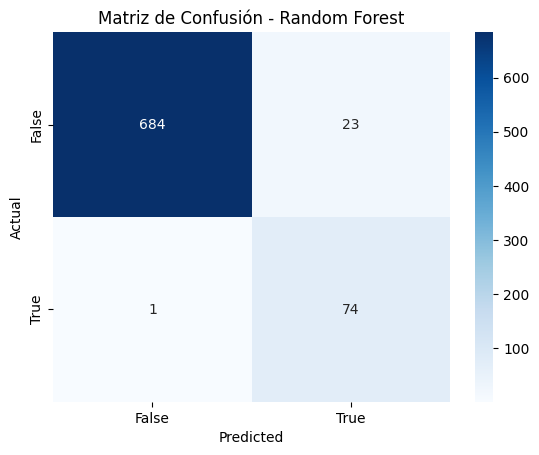

In [215]:
# ✅ 6. Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión - Random Forest")
plt.show()


In [216]:

# ✅ 7. Importancia de las variables
importances = pd.DataFrame({
    "Feature": features,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)


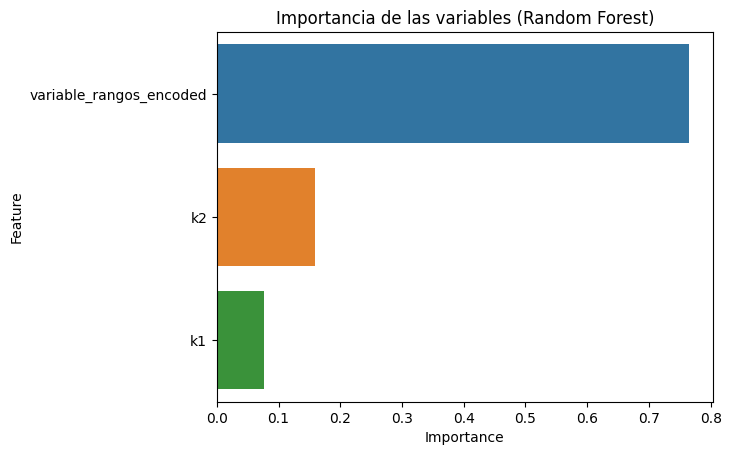

In [217]:


sns.barplot(x="Importance", y="Feature", data=importances)
plt.title("Importancia de las variables (Random Forest)")
plt.show()


In [218]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import randint

In [222]:
df.columns

Index(['Shared_Markers', 'k0', 'k1', 'k2', 'Share_allele', 'Value',
       'True_positive', 'Datos', 'Value_range', 'log10_Value',
       'variable_rangos_encoded'],
      dtype='object')

In [223]:
features

['k1', 'k2', 'variable_rangos_encoded']

In [219]:

# Definir el espacio de búsqueda
param_dist = {
    'n_estimators': randint(100,  2000),
    'max_depth': [5, 10, 20, 50, None],
    'min_samples_split': [2, 5, 10,50],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced',"balanced_subsample", None]
}


In [220]:


# Inicializar el modelo base
rf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=50, cv=5, scoring='f1', random_state=42, n_jobs=-1, verbose=1
)

# Ajustar al set de entrenamiento
random_search.fit(X_train, y_train)

# Mejor modelo
best_rf = random_search.best_estimator_

# Predicciones y evaluación
y_pred = best_rf.predict(X_test)
print("Mejores parámetros:", random_search.best_params_)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 1787}
              precision    recall  f1-score   support

       False       0.98      0.99      0.99       707
        True       0.93      0.84      0.88        75

    accuracy                           0.98       782
   macro avg       0.95      0.92      0.93       782
weighted avg       0.98      0.98      0.98       782



In [224]:
from sklearn.model_selection import GridSearchCV

# Espacio de búsqueda más acotado
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}


In [225]:

grid_search = GridSearchCV(
    rf, param_grid=param_grid,
    cv=5, scoring='f1', n_jobs=-1, verbose=1
)

grid_search.fit(X_train, y_train)
best_rf_grid = grid_search.best_estimator_

# Predicciones y evaluación
y_pred_grid = best_rf_grid.predict(X_test)
print("Mejores parámetros (Grid):", grid_search.best_params_)
print(classification_report(y_test, y_pred_grid))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores parámetros (Grid): {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

       False       1.00      0.97      0.98       707
        True       0.76      0.99      0.86        75

    accuracy                           0.97       782
   macro avg       0.88      0.98      0.92       782
weighted avg       0.98      0.97      0.97       782



In [226]:
from sklearn.metrics import classification_report

# Supongamos que ya tienes:
# y_test: valores reales
# y_pred: predicciones del modelo
# X_test: contiene columna log10_Value

# Combinar todo en un DataFrame
results = X_test.copy()
results["y_true"] = y_test.values
results["y_pred"] = y_pred

# Agregar una columna con los rangos de log10_Value
def categorize_log10(val):
    if val < 2:
        return "<100"
    elif val < 3:
        return "100–999"
    else:
        return "1000+"

results["Value_range"] = results["log10_Value"].apply(categorize_log10)

# Evaluar por cada rango
for group, subset in results.groupby("Value_range"):
    print(f"🔹 Rango: {group}")
    print(classification_report(subset["y_true"], subset["y_pred"]))
    print("-" * 40)


KeyError: 'log10_Value'

In [227]:
from sklearn.metrics import classification_report

# Suponiendo que ya tienes: X_test, y_test, y_pred
# Asegúrate de que X_test tenga la columna "log10_Value"

# Combinar datos reales, predichos y características
results = X_test.copy()
results["y_true"] = y_test.values
results["y_pred"] = y_pred

# Filtrar solo casos con log10_Value >= 2 (equivale a LR ≥ 100)
subset = results[results["log10_Value"] >= 3]

# Reporte de clasificación en ese subconjunto
print("🔎 Evaluación solo con log10_Value ≥ 3 (LR ≥ 1000)")
print(classification_report(subset["y_true"], subset["y_pred"]))


KeyError: 'log10_Value'

In [228]:
subset_low = results[results["log10_Value"] < 2]
print("🔎 Evaluación con log10_Value < 2 (LR < 100)")
print(classification_report(subset_low["y_true"], subset_low["y_pred"]))


KeyError: 'log10_Value'

In [38]:
features = ["k1", "k2", "Share_allele", "log10_Value"]
X = df[features]
y = df["True_positive"]  # o el nombre de tu variable objetivo


In [43]:
pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/150.0 MB 3.5 MB/s eta 0:00:43
   ---------------------------------------- 0.5/150.0 MB 5.8 MB/s eta 0:00:26
   ---------------------------------------- 0.8/150.0 MB 5.3 MB/s eta 0:00:29
   ---------------------------------------- 0.9/150.0 MB 5.4 MB/s eta 0:00:28
   ---------------------------------------- 1.3/150.0 MB 5.4 MB/s eta 0:00:28
   ---------------------------------------- 1.6/150.0 MB 5.5 MB/s eta 0:00:27
    --------------------------------------- 1.9/150.0 MB 5.8 MB/s eta 0:00:26
    --------------------------------------- 2.5/150.0 MB 6.9 MB/s eta 0:00:22
    --------------------------------------- 2.8/150.0 MB 6.8 MB/s eta 0:00:22
    --------------------------------------- 3.0/150.0 MB 6.6 MB/s eta 0:00:23
    --------------------------------------- 3.3/150.0 MB 6.5 MB/s eta 0:00:23
    --------------------------------------- 3.6/150.0 MB 6.6 MB/s eta 0


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\Miranda Córdova\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [229]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import randint, uniform
import numpy as np

In [238]:
#features = ["k1", "k2", "Share_allele", "log10_Value"]
features = ["k1", "k2", "variable_rangos_encoded"]

X = df[features]
y = df["True_positive"]  # o el nombre de tu variable objetivo


In [241]:
# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Definir el modelo base
xgb_model = XGBClassifier(eval_metric='aucpr')

# Definir espacio de búsqueda para RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 2000),  # número de árboles
    'max_depth': [5, 10, 20, 50],        # profundidad del árbol
    'learning_rate': uniform(0.01, 0.3), # tasa de aprendizaje
    'min_child_weight': [1, 3, 5],       # similar a min_samples_split
    'gamma': [0, 0.1, 0.2],              # reducción de impureza mínima
    'subsample': [0.6, 0.8, 1.0],        # fracción de muestras usadas por árbol
    'colsample_bytree': [0.6, 0.8, 1.0], # similar a max_features
    'scale_pos_weight': [1, 2, 5],       # para clases desbalanceadas (en vez de class_weight)
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # número de combinaciones aleatorias a probar
    cv=5,       # validación cruzada 5-fold
    scoring='f1',  # puedes usar 'accuracy', 'recall', 'roc_auc', etc.
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [242]:

# Ejecutar búsqueda
random_search.fit(X_train, y_train)

# Predecir con el mejor modelo
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Reporte de métricas
print("Mejores parámetros encontrados:")
print(random_search.best_params_)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros encontrados:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.09386810253902757, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 1868, 'scale_pos_weight': 1, 'subsample': 0.6}

Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.98      0.99      0.98       883
        True       0.90      0.79      0.84        94

    accuracy                           0.97       977
   macro avg       0.94      0.89      0.91       977
weighted avg       0.97      0.97      0.97       977



In [55]:
features = ["k0","k1", "k2", "Share_allele","Shared_Markers", "log10_Value"]
X = df[features]
y = df["True_positive"]  # o el nombre de tu variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.99      0.97      0.98       883
        True       0.78      0.87      0.82        94

    accuracy                           0.96       977
   macro avg       0.88      0.92      0.90       977
weighted avg       0.97      0.96      0.97       977



C:\Users\Miranda Córdova\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:35:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [253]:
X[["k1", "k2", "Share_allele", "log10_Value"]].corr()


,k1,k2,Share_allele,log10_Value
k1,1.000000,-0.957918,-0.839120,-0.080189
k2,-0.957918,1.000000,0.959944,0.296493
Share_allele,-0.839120,0.959944,1.000000,0.483579
log10_Value,-0.080189,0.296493,0.483579,1.000000


In [254]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from scipy.stats import uniform, reciprocal
import numpy as np


In [255]:
X = df[["k1", "k2", "variable_rangos_encoded"]]
y = df["True_positive"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [256]:
svc = SVC(probability=True)

param_dist = {
    'C': uniform(0.1, 10),  # valores entre 0.1 y 10
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # solo para kernels no lineales
    'degree': [2, 3, 4],  # solo para kernel='poly'
}


In [257]:
random_search = RandomizedSearchCV(
    svc,
    param_distributions=param_dist,
    n_iter=50,  # número de combinaciones a probar
    scoring='f1',  # puedes usar 'recall', 'precision', 'accuracy', etc.
    cv=5,  # validación cruzada con 5 folds
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=SVC(probability=True), n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018470E0FFD0>,
                                        'degree': [2, 3, 4],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1, 1],
                                        'kernel': ['linear', 'rbf', 'poly',
                                                   'sigmoid']},
                   random_state=42, scoring='f1', verbose=1)

In [258]:
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Mejores hiperparámetros encontrados:
{'C': 1.9485445552552705, 'degree': 4, 'gamma': 'auto', 'kernel': 'rbf'}

Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.98      0.99      0.98       883
        True       0.90      0.78      0.83        94

    accuracy                           0.97       977
   macro avg       0.94      0.88      0.91       977
weighted avg       0.97      0.97      0.97       977

